Figure 5a

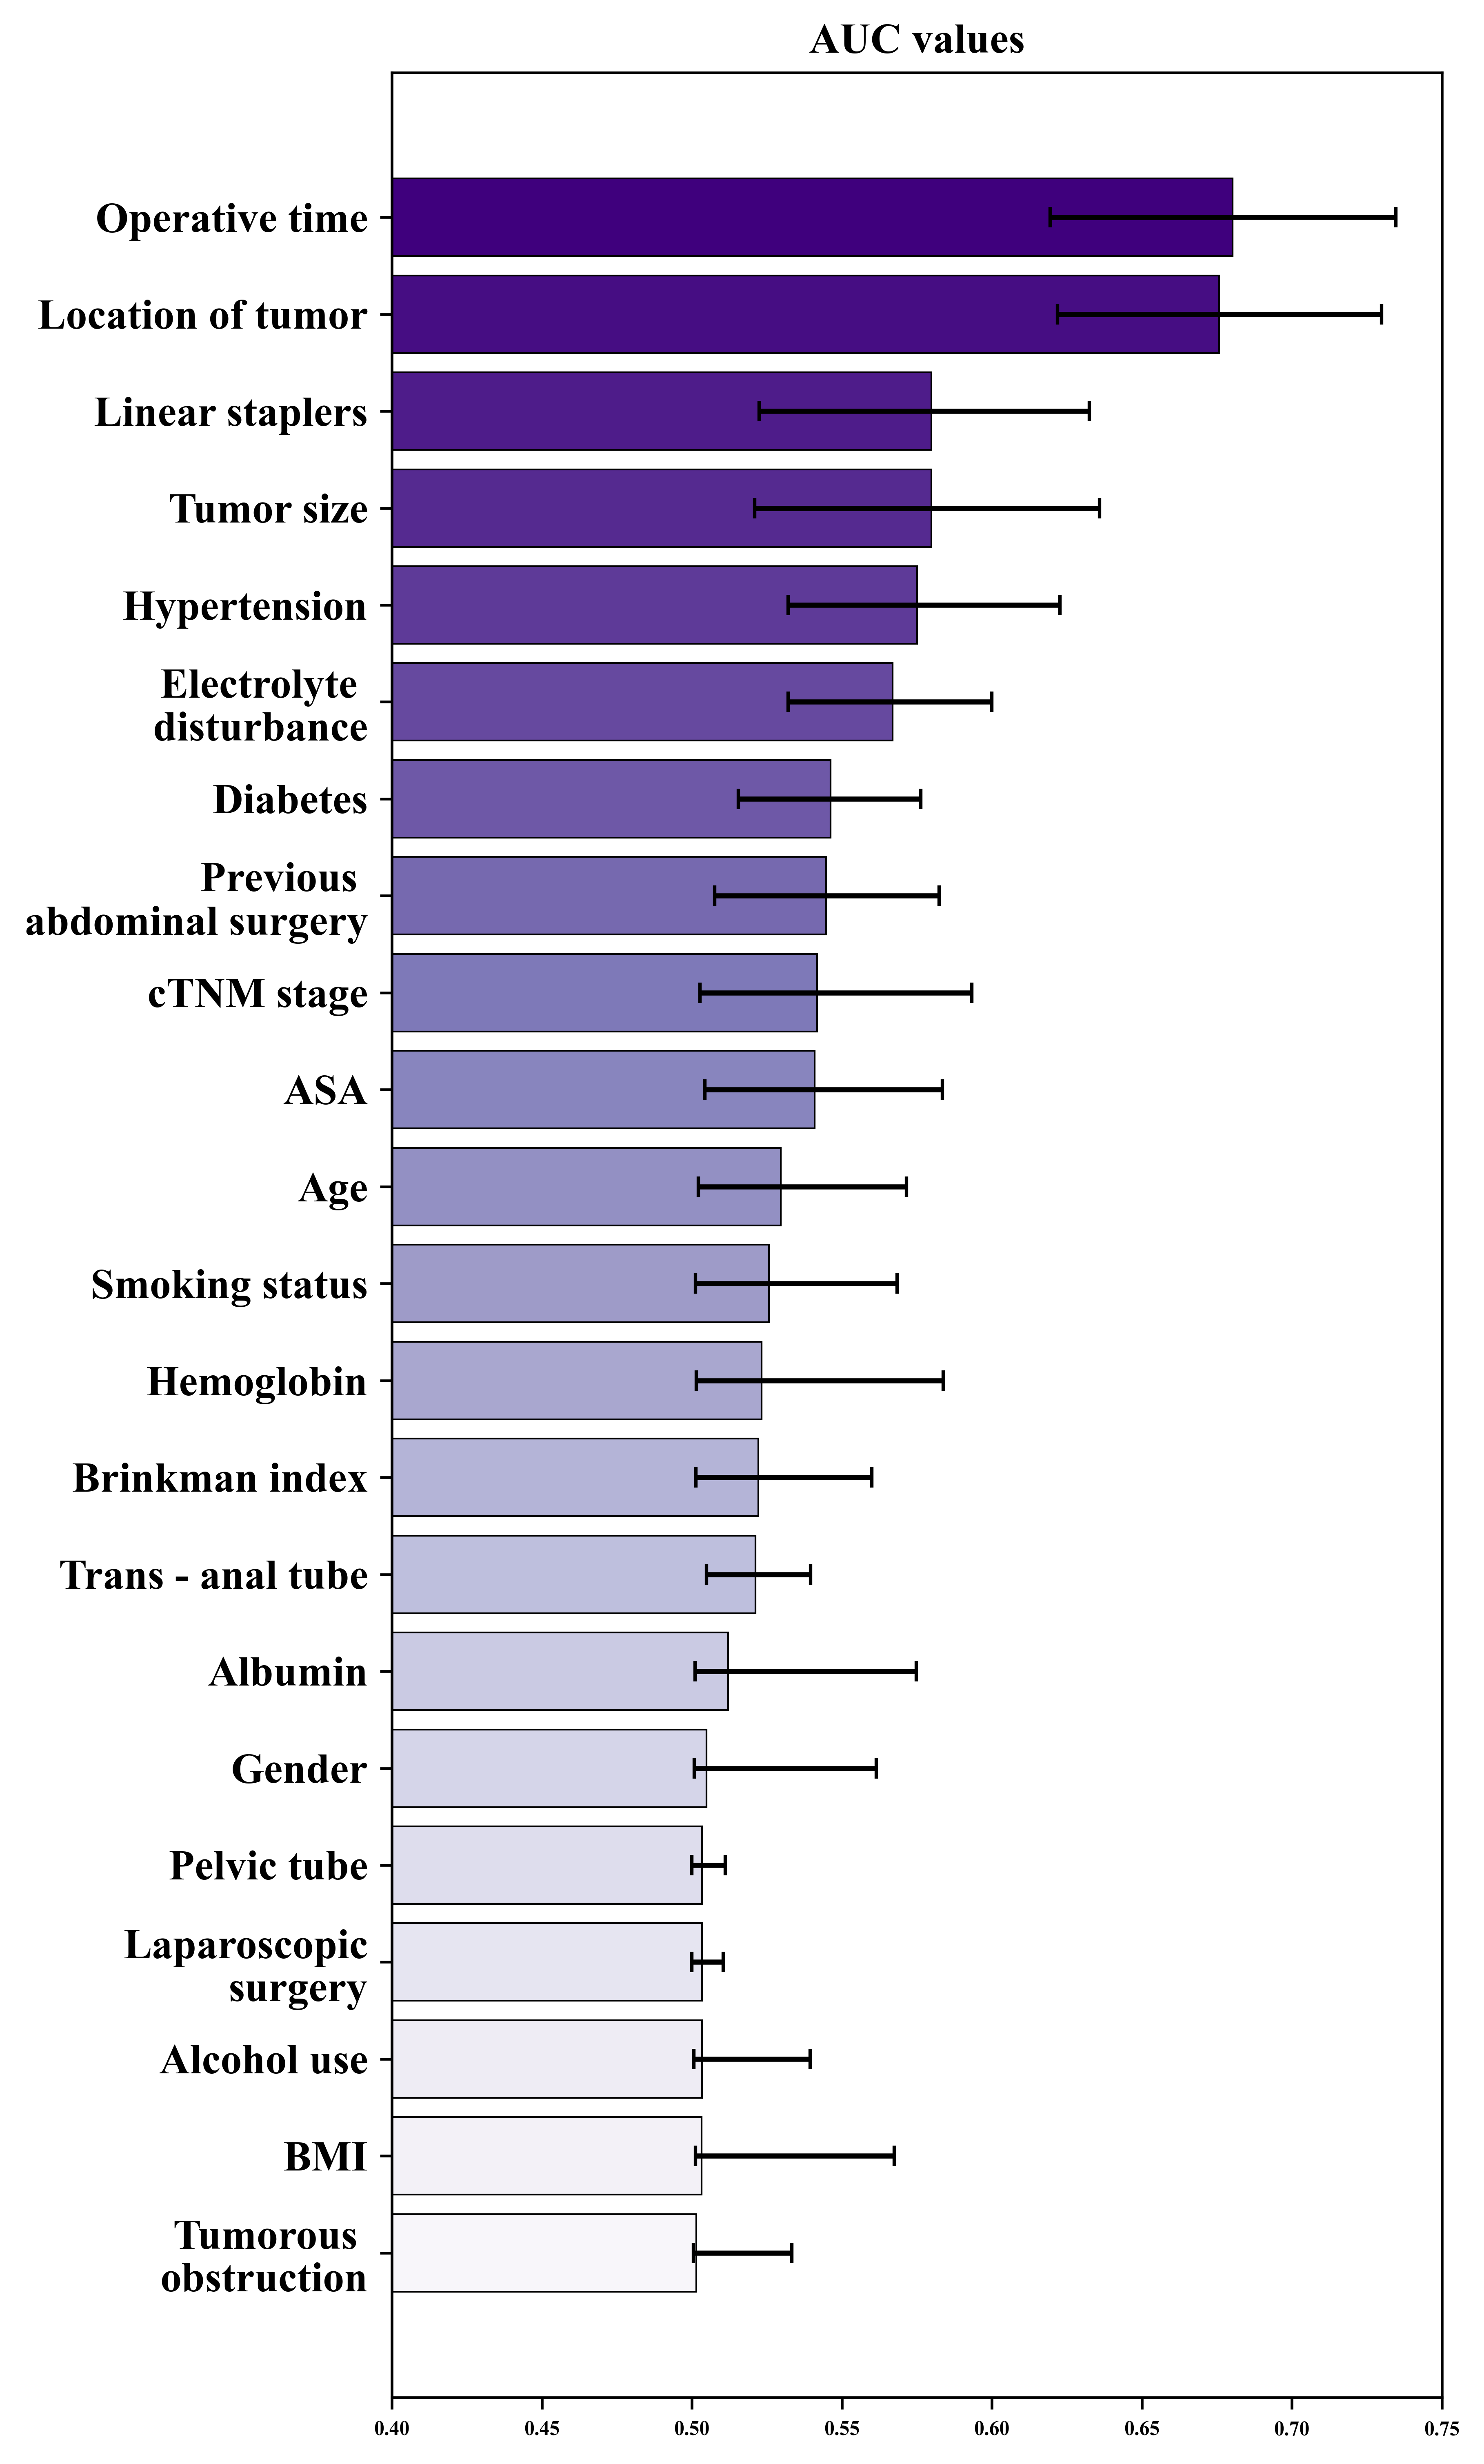


AUCand 95%CI：
Operative time: AUC=0.680, 95%CI=(0.619-0.735)
Location of tumor: AUC=0.676, 95%CI=(0.622-0.730)
Linear staplers: AUC=0.580, 95%CI=(0.522-0.632)
Tumor size: AUC=0.580, 95%CI=(0.521-0.636)
Hypertension: AUC=0.575, 95%CI=(0.532-0.623)
Electrolyte 
disturbance: AUC=0.567, 95%CI=(0.532-0.600)
Diabetes: AUC=0.546, 95%CI=(0.516-0.576)
Previous 
abdominal surgery: AUC=0.545, 95%CI=(0.508-0.582)
cTNM stage: AUC=0.542, 95%CI=(0.503-0.593)
ASA: AUC=0.541, 95%CI=(0.504-0.584)
Age: AUC=0.530, 95%CI=(0.502-0.571)
Smoking status: AUC=0.526, 95%CI=(0.501-0.568)
Hemoglobin: AUC=0.523, 95%CI=(0.501-0.584)
Brinkman index: AUC=0.522, 95%CI=(0.501-0.560)
Trans - anal tube: AUC=0.521, 95%CI=(0.505-0.540)
Albumin: AUC=0.512, 95%CI=(0.501-0.575)
Gender: AUC=0.505, 95%CI=(0.501-0.562)
Pelvic tube: AUC=0.503, 95%CI=(0.500-0.511)
Laparoscopic
surgery: AUC=0.503, 95%CI=(0.500-0.510)
Alcohol use: AUC=0.503, 95%CI=(0.501-0.539)
BMI: AUC=0.503, 95%CI=(0.501-0.568)
Tumorous 
obstruction: AUC=0.501, 95

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn.utils import resample

df = pd.read_excel(r"control.xlsx")

plt.rcParams['figure.dpi'] = 600

plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['axes.unicode_minus'] = False

X = df.drop(['al', 'id', 'stoma', 'y_pred', 'proba'], axis=1)
y = df['stoma']

custom_labels = {
    'gender': 'Gender',
    'agebz': 'Age',
    'bmibz': 'BMI',
    'bindex': 'Brinkman index',
    'smoke': 'Smoking status',
    'drink': 'Alcohol use',
    'hyper': 'Hypertension',
    'dia': 'Diabetes',
    'sur': 'Previous \nabdominal surgery',
    'asabz': 'ASA',
    'hb': 'Hemoglobin',
    'alb': 'Albumin',
    'electrolyte': 'Electrolyte \ndisturbance',
    'sizebz': 'Tumor size',
    'obstruction': 'Tumorous \nobstruction',
    'dist': 'Location of tumor',
    'stagebz': 'cTNM stage',
    'gangguan': 'Trans - anal tube',
    'yinliu': 'Pelvic tube',
    'type': 'Laparoscopic\nsurgery',
    'timebz': 'Operative time',
    'bhq': 'Linear staplers'
}

def calculate_auc_ci(feature_data, y_true, n_bootstrap=1000, confidence_level=0.95):

    boot_aucs = []
    combined_data = np.column_stack((feature_data, y_true))
    
    for _ in range(n_bootstrap):
        boot_sample = resample(combined_data, replace=True)
        boot_feature = boot_sample[:, 0]
        boot_y = boot_sample[:, 1]
        
        fpr, tpr, _ = roc_curve(boot_y, boot_feature)
        boot_auc = auc(fpr, tpr)
        if boot_auc < 0.5:
            fpr, tpr, _ = roc_curve(boot_y, -boot_feature)
            boot_auc = auc(fpr, tpr)
        boot_aucs.append(boot_auc)
    
    alpha = 1 - confidence_level
    auc_lower = np.percentile(boot_aucs, 100 * alpha / 2)
    auc_upper = np.percentile(boot_aucs, 100 * (1 - alpha / 2))
    auc_mean = np.mean(boot_aucs)
    
    return auc_mean, auc_lower, auc_upper


auc_values = []
auc_lowers = []  
auc_uppers = []  
curves = []
feature_names = []
for feature in X.columns:
    X_feature = X[feature].values
    fpr, tpr, thresholds = roc_curve(y, X_feature)
    roc_auc = auc(fpr, tpr)
    if roc_auc < 0.5:
        X_feature = -X_feature
        fpr, tpr, thresholds = roc_curve(y, X_feature)
        roc_auc = auc(fpr, tpr)
    _, auc_lower, auc_upper = calculate_auc_ci(X_feature, y.values)
    auc_values.append(roc_auc)
    auc_lowers.append(auc_lower)
    auc_uppers.append(auc_upper)
    curves.append((fpr, tpr))
    feature_names.append(feature)
sorted_indices = np.argsort(auc_values)[::-1]
sorted_aucs = [auc_values[i] for i in sorted_indices]
sorted_lowers = [auc_lowers[i] for i in sorted_indices]
sorted_uppers = [auc_uppers[i] for i in sorted_indices]
sorted_features = [feature_names[i] for i in sorted_indices]

reversed_aucs = sorted_aucs[::-1]
reversed_lowers = sorted_lowers[::-1]
reversed_uppers = sorted_uppers[::-1]

lower_errors = [auc_val - lower for auc_val, lower in zip(reversed_aucs, reversed_lowers)]  
upper_errors = [upper - auc_val for auc_val, upper in zip(reversed_aucs, reversed_uppers)]  
xerr = np.array([lower_errors, upper_errors])  

plt.figure(figsize=(6, 10), dpi=600)
cmap = plt.get_cmap('Purples_r')

bars = plt.barh(
    [custom_labels.get(f, f) for f in sorted_features[::-1]],  
    reversed_aucs,  
    color=[cmap(i / len(sorted_indices)) for i in range(len(sorted_indices) - 1, -1, -1)],
    xerr=xerr,  
    capsize=3,  
    edgecolor='black', 
    linewidth=0.5
)

plt.title('AUC values', fontsize=12.5, weight='bold')
plt.xticks(fontproperties='Times New Roman', fontsize=6, weight='bold')
plt.yticks(fontproperties='Times New Roman', fontsize=12.5, weight='bold')
plt.xlim(0.4, 0.75)


plt.tight_layout(pad=0.5)
#plt.savefig(r"stomaauc.jpg", dpi=600)
plt.show()

print("\nAUCand 95%CI：")
for i, feature in enumerate(sorted_features):
    print(f"{custom_labels.get(feature, feature)}: AUC={sorted_aucs[i]:.3f}, 95%CI=({sorted_lowers[i]:.3f}-{sorted_uppers[i]:.3f})")

Figure 5b

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['axes.unicode_minus'] = False
# data
categories = [
    "Gender (male)", "Age (<70)", "BMI", "Brinkman index", 
    "Smoking status", "Alcohol use", "Hypertension", "Diabetes",
    "Previous \nabdominal surgery", "ASA", "Hemoglobin", "Albumin",
    "Electrolyte \ndisturbance", "Tumor size", "Tumorous obstruction",
    "Location of tumor", "cTNM stage", "Trans-anal tube",
    "Operative time", "Linear staplers"
]

# uni
hr1 = [0.959, 1.414, 0.992, 1.0, 0.718, 1.066, 0.465, 0.332, 0.538, 0.634, 
       1.006, 1.019, 0.286, 0.753, 1.041, 0.762, 0.838, 0.093, 1.011, 1.765]
l1 = [0.623, 0.864, 0.929, 0.999, 0.42, 0.559, 0.286, 0.148, 0.305, 0.394, 
      0.994, 0.961, 0.139, 0.601, 0.482, 0.685, 0.614, 0.011, 1.006, 1.234]
h1 = [1.474, 2.448, 1.059, 1.001, 1.227, 2.033, 0.757, 0.742, 0.949, 1.021, 
      1.017, 1.081, 0.589, 0.943, 2.248, 0.848, 1.143, 0.764, 1.015, 2.524]
p1 = [0.848, 0.159, 0.804, 0.617, 0.226, 0.845, 0.002, 0.007, 0.032, 0.061, 
      0.334, 0.531, 0.001, 0.013, 0.919, 0.0, 0.264, 0.027, 0.0, 0.002]
# multi
hr2 = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 0.41, 0.306, np.nan, 
       np.nan, np.nan, np.nan, 0.29, 0.76, np.nan, 0.796, np.nan, 0.087, 
       1.011, 1.778]
l2 = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 0.233, 0.126, np.nan, 
      np.nan, np.nan, np.nan, 0.133, 0.616, np.nan, 0.707, np.nan, 0.01, 
      1.006, 1.169]
h2 = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 0.719, 0.743, np.nan, 
      np.nan, np.nan, np.nan, 0.636, 0.925, np.nan, 0.897, np.nan, 0.753, 
      1.016, 2.705]
p2 = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 0.002, 0.009, np.nan, 
      np.nan, np.nan, np.nan, 0.002, 0.006, np.nan, 0.0, np.nan, 0.027, 
      0.0, 0.007]

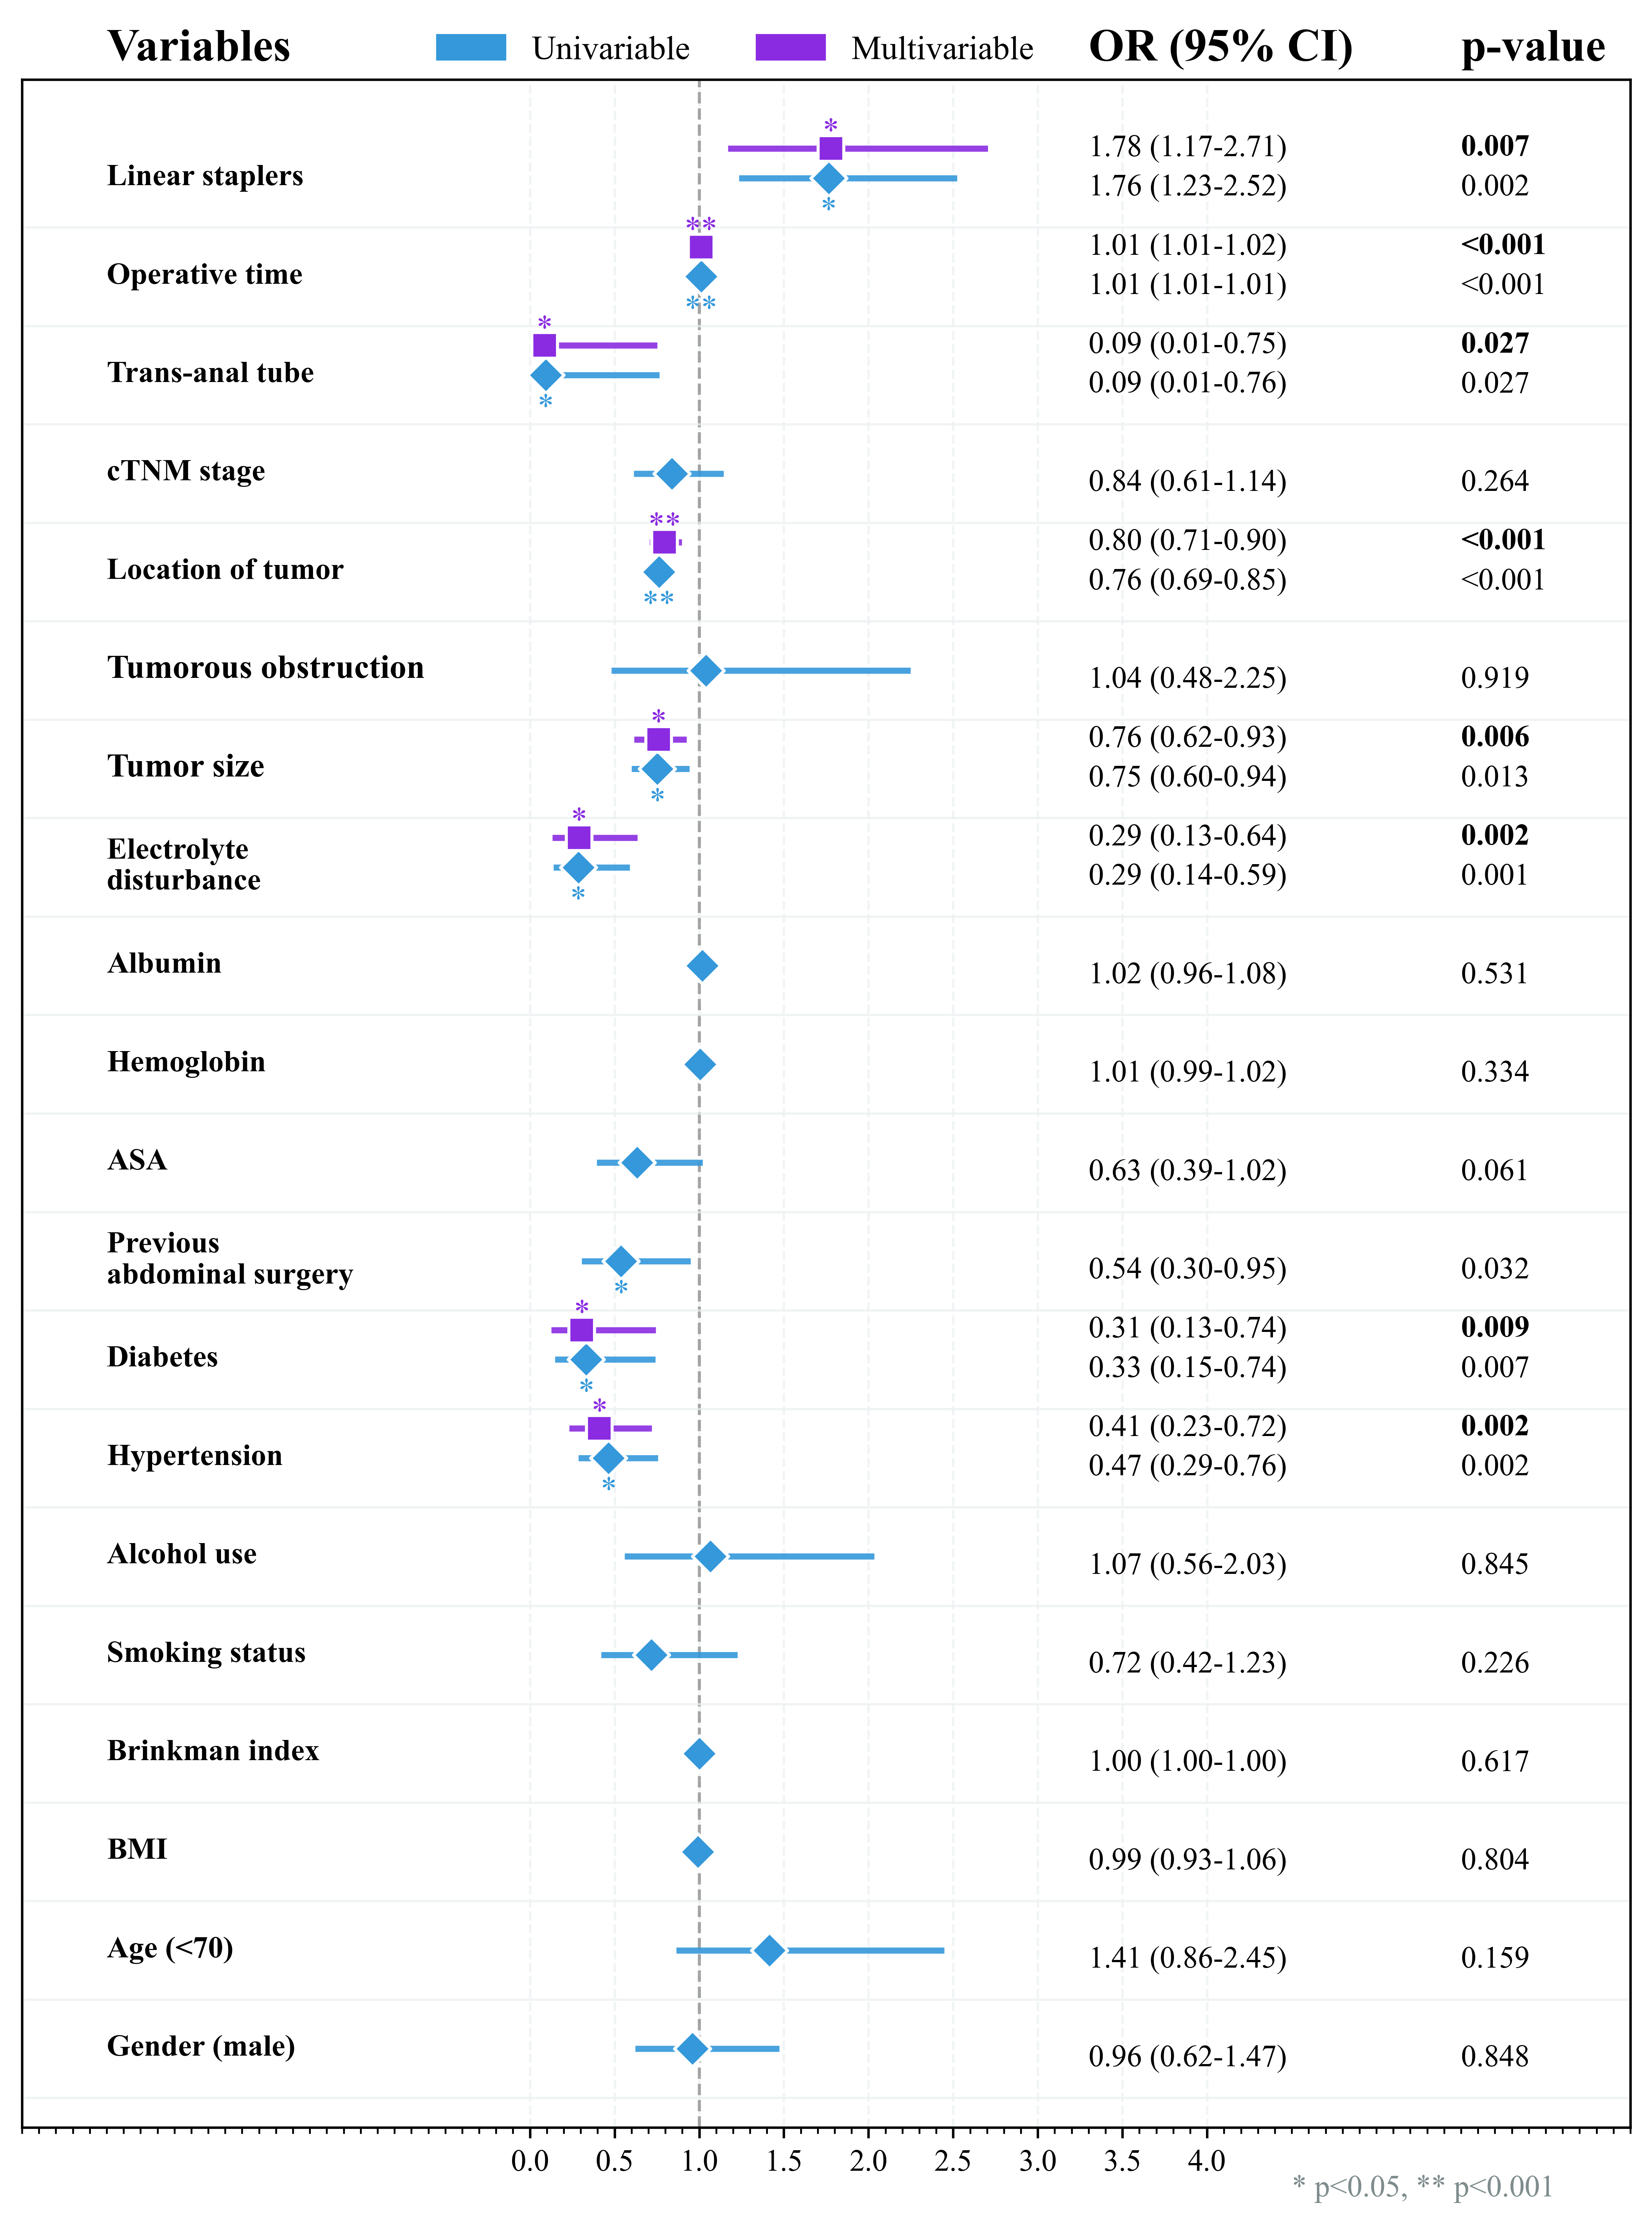

In [17]:
plt.figure(figsize=(7.5, 10),dpi=600)
plt.axvline(x=1, color='gray', linestyle='--', linewidth=1, alpha=0.7)

UNIVARIATE_COLOR = '#3498db'  
MULTIVARIATE_COLOR = 'blueviolet'  
TEXT_COLOR = 'black'
GRID_COLOR = '#ecf0f1'
FONT_SIZE = 10
MARKER_SIZE = 70

# uni
for i in range(len(categories)):
    if not np.isnan(hr1[i]):
        # 95%CI
        plt.hlines(y=i, xmin=l1[i], xmax=h1[i], 
                  color=UNIVARIATE_COLOR, linewidth=2, alpha=0.9)
        # OR
        plt.scatter(hr1[i], i, color=UNIVARIATE_COLOR, s=MARKER_SIZE, 
                   marker='D', edgecolor='white', linewidth=1, zorder=3)
        # p
        if p1[i] < 0.001:
            star = '**'
        elif p1[i] < 0.05:
            star = '*'
        else:
            star = ''
        plt.text(hr1[i], i-0.5, star, fontsize=11, 
                color=UNIVARIATE_COLOR, ha='center', va='bottom')

# multi
for i in range(len(categories)):
    if not np.isnan(hr2[i]):
        plt.hlines(y=i+0.3, xmin=l2[i], xmax=h2[i], 
                  color=MULTIVARIATE_COLOR, linewidth=2, alpha=0.9)
        plt.scatter(hr2[i], i+0.3, color=MULTIVARIATE_COLOR, s=MARKER_SIZE, 
                   marker='s', edgecolor='white', linewidth=1, zorder=3)
        if p2[i] < 0.001:
            star = '**'
        elif p2[i] < 0.05:
            star = '*'
        else:
            star = ''
        plt.text(hr2[i], i+0.3, star, fontsize=11, 
                color=MULTIVARIATE_COLOR, ha='center', va='bottom')

for i in range(len(categories)):
    group_fontsize = FONT_SIZE
    if any(substr in categories[i] for substr in ['Demographic', 'Comorbidities', 'Laboratory', 'Tumor', 'Intraoperative']):
        group_fontsize = FONT_SIZE+1
        plt.text(-2.5, i, categories[i], ha='left', va='center', 
                fontsize=group_fontsize, fontweight='bold',color=TEXT_COLOR, )
    else:
        plt.text(-2.5, i, categories[i], ha='left', va='center', 
                fontsize=group_fontsize,fontweight='bold', color=TEXT_COLOR)
    
    if not np.isnan(hr1[i]):
        ci_text = f"{hr1[i]:.2f} ({l1[i]:.2f}-{h1[i]:.2f})"
        p_text = f"{p1[i]:.3f}".replace("0.000", "<0.001")
        plt.text(3.3, i-0.1, ci_text, ha='left', va='center', 
               fontsize=FONT_SIZE, color='black',weight='normal')
        plt.text(5.5, i-0.1, p_text, ha='left', va='center', 
               fontsize=FONT_SIZE, color='black',weight='normal')
    
    if not np.isnan(hr2[i]):
        ci_text = f"{hr2[i]:.2f} ({l2[i]:.2f}-{h2[i]:.2f})"
        p_text = f"{p2[i]:.3f}".replace("0.000", "<0.001")
        plt.text(3.3, i+0.3, ci_text, ha='left', va='center', 
                fontsize=FONT_SIZE, color='black',weight='normal')
        plt.text(5.5, i+0.3, p_text, ha='left', va='center', 
                fontsize=FONT_SIZE, color='black',weight='bold')

plt.yticks([])
plt.xticks(np.arange(0, 4.1, 0.5))
plt.xlim(-3, 6.5)
plt.ylim(-0.8, len(categories))

for i in range(len(categories)):
    plt.axhline(y=i-0.5, color=GRID_COLOR, linestyle='-', linewidth=0.8, alpha=0.7)

plt.text(-2.5, len(categories)+0.3, 'Variables', ha='left', va='center', fontsize=15, fontweight='bold')
plt.text(3.3, len(categories)+0.3, 'OR (95% CI)', ha='left', va='center',fontsize=15, fontweight='bold')
plt.text(5.5, len(categories)+0.3, 'p-value', ha='left', va='center', fontsize=15, fontweight='bold')

uni_patch = mpatches.Patch(color=UNIVARIATE_COLOR, label='Univariable')
multi_patch = mpatches.Patch(color=MULTIVARIATE_COLOR, label='Multivariable')
plt.legend(handles=[uni_patch, multi_patch], 
          loc=(0.25,1), framealpha=1,frameon=False, fontsize=11,ncol=2)

plt.text(4.5, -1.5, "* p<0.05, ** p<0.001", fontsize=10, color='#7f8c8d')

plt.grid(axis='x', color=GRID_COLOR, linestyle='--', alpha=0.7)
plt.gca().xaxis.set_minor_locator(MultipleLocator(0.1))
plt.tight_layout(pad=0.5)
#plt.savefig(r"forest.jpg",dpi=600)
plt.show()  